1. Segmentação de Clientes (Perfil Comportamental e Financeiro)
Objetivo: Agrupar os clientes com base em comportamentos financeiros, operacionais e histórico bancário.

Variáveis principais:

Renda e operações financeiras: renda_cart, Qtd_Op_em_cart, VlrLiberado_12meses_Consig
Histórico de pedidos e cancelamentos: Pedidos, Qtd_Pedidos_cancelados, Saldo_Gerado_cancelado
Relacionamento com o banco: Historico_QtdOutrosBancos, Tempocliente
Perguntas a responder:

Existem clientes que operam pouco, mas têm alta renda (potencial de cross-sell)?
Quem são os clientes com alta taxa de cancelamento?
Que grupos têm maior fidelidade ao banco com base no tempo e histórico?
Método recomendado:

K-means: Agrupar clientes com base em perfis financeiros e operacionais.
DBSCAN: Identificar grupos de clientes com comportamentos densos específicos, como alta operação e baixo cancelamento.
2. Identificação de Clientes em Risco de Churn
Objetivo: Detectar clusters de clientes com comportamentos associados ao risco de churn (desistência do serviço).

Variáveis principais:

Interação recente: Pedidos_Mes, Saldo_Mes
Relacionamento de longo prazo: Tempocliente, Historico_QtdOutrosBancos
Problemas operacionais: Qtd_Pedidos_cancelados, Meses_Distintos_Pedido_cancelados
Perguntas a responder:

Existem grupos de clientes que têm poucas operações recentes, mas alta taxa de cancelamento?
Quem são os clientes que estão reduzindo a frequência de operações?
Método recomendado:

Hierarchical Clustering: Para explorar estruturas hierárquicas nos dados e identificar padrões complexos.
PCA + K-means: Reduzir a dimensionalidade e focar em variáveis que explicam o comportamento.

In [57]:
import pandas as pd
import random
import numpy as np

In [58]:
#criacao dos dados
random.seed(600)  # 
np.random.seed(600)  

# Função para gerar CPF
def gerar_tipo_cpf():
    cpf = [random.randint(0, 9) for _ in range(9)]
    for _ in range(2):
        soma = sum(x * y for x, y in zip(cpf, range(len(cpf) + 1, 1, -1)))
        resto = soma % 11
        cpf.append(11 - resto if resto > 1 else 0)
    return "".join(map(str, cpf))

# Gerar 10k linhas de dados simulados
n_linhas = 10000
data = {
    "Cliente_ID": [gerar_tipo_cpf() for _ in range(n_linhas)],  # Identificador único do cliente
    "Qtd_Interacoes_Plataforma": np.random.randint(1, 100, n_linhas),  # Número de interações em uma plataforma
    "Gasto_Total": np.random.uniform(1000, 50000, n_linhas),  # Valor total gasto pelo cliente
    "Qtd_Compras_12meses": np.random.randint(0, 50, n_linhas),  # Quantidade de compras nos últimos 12 meses
    "Valor_Compras_12meses": np.random.uniform(1000, 100000, n_linhas),  # Valor total de compras nos últimos 12 meses
    "Meses_Compras": np.random.randint(0, 12, n_linhas),  # Meses distintos com compras
    "Qtd_Pedidos": np.random.randint(0, 50, n_linhas),  # Total de pedidos realizados
    "Pedidos_Mensais": np.random.randint(0, 5, n_linhas),  # Média mensal de pedidos
    "Meses_Atividade": np.random.randint(0, 12, n_linhas),  # Número de meses com atividades registradas
    "Qtd_Pedidos_Devolvidos": np.random.randint(0, 50, n_linhas),  # Total de pedidos devolvidos
    "Meses_Devolucoes": np.random.randint(0, 12, n_linhas),  # Meses distintos com devoluções
    "Valor_Devolvido": np.random.uniform(0, 100000, n_linhas),  # Valor total de devoluções
    "Gasto_Medio_Mensal": np.random.uniform(0, 10000, n_linhas),  # Gasto médio mensal
    "Qtd_Outros_Fornecedores": np.random.randint(0, 20, n_linhas),  # Quantidade de outros fornecedores utilizados
    "Valor_Devolvido_Mensal": np.random.uniform(0, 10000, n_linhas),  # Valor médio devolvido por mês
    "Porcentagem_Engajamento": np.random.uniform(0, 1, n_linhas),  # Porcentagem de engajamento (SOW adaptado)
    "Tempo_Cliente": np.random.randint(0, 30, n_linhas),  # Tempo total como cliente (em anos)
}


df_pd_cluster = pd.DataFrame(data)

In [72]:
def request_file(url):
    from os.path import basename
    from urllib.request import urlretrieve
    path = basename(url)
    urlretrieve(url, path)
    return path

def get_dfs_dict(data_file):
    from pandas import read_csv
    from zipfile import ZipFile
    with ZipFile(data_file) as zip_archive:
        return {csv[-11:-4].lower(): read_csv(zip_archive.open(csv), encoding='cp1252', sep=';')
                for csv in [item.filename for item in zip_archive.filelist
                            if item.filename.lower().endswith('.csv')]}

In [73]:
dfs = get_dfs_dict(request_file('https://www.gov.br/anp/pt-br/centrais-de-conteudo/paineis-dinamicos-da-anp/paineis-dinamicos-do-abastecimento/painel-dinamico-dado-lubrificante.zip'))
for csv in dfs:
    print(csv)
    print(dfs[csv].head())

anexo_a
    Ano  Mês  Código do Produto                  Descrição do Produto  \
0  2015   10          620101002  ENGRENAGENS E SISTEMAS CIRCULATÓRIOS   
1  2015   10          620501001                            CICLO OTTO   
2  2015   10          620501001                            CICLO OTTO   
3  2015   10          620501001                            CICLO OTTO   
4  2015   10          620501002                          CICLO DIESEL   

  Região de Origem UF de Origem Região do Destinatário UF do Destinatário  \
0              SUL           PR                    SUL                 PR   
1              SUL           PR               NORDESTE                 AL   
2              SUL           PR                    SUL                 PR   
3              SUL           PR                    SUL                 SC   
4              SUL           PR                    SUL                 PR   

   Volume(L)  
0       2036  
1        300  
2       5464  
3       6524  
4       2428  


In [59]:
df_pd_cluster.columns

Index(['Cliente_ID', 'Qtd_Interacoes_Plataforma', 'Gasto_Total',
       'Qtd_Compras_12meses', 'Valor_Compras_12meses', 'Meses_Compras',
       'Qtd_Pedidos', 'Pedidos_Mensais', 'Meses_Atividade',
       'Qtd_Pedidos_Devolvidos', 'Meses_Devolucoes', 'Valor_Devolvido',
       'Gasto_Medio_Mensal', 'Qtd_Outros_Fornecedores',
       'Valor_Devolvido_Mensal', 'Porcentagem_Engajamento', 'Tempo_Cliente'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer, calculate_kmo
import matplotlib.pyplot as plt

df = df_pd_cluster.copy()


quantitative_columns = [
    'Cliente_ID', 'Qtd_Interacoes_Plataforma', 'Gasto_Total', 'Qtd_Compras_12meses',
    'Valor_Compras_12meses', 'Meses_Compras', 'Qtd_Pedidos', 'Pedidos_Mensais',
    'Meses_Atividade', 'Qtd_Pedidos_Devolvidos', 'Meses_Devolucoes', 'Valor_Devolvido',
    'Gasto_Medio_Mensal', 'Qtd_Outros_Fornecedores', 'Valor_Devolvido_Mensal',
    'Porcentagem_Engajamento', 'Tempo_Cliente']

data = df[quantitative_columns]



In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01, random_state=42)
outliers = iso_forest.fit_predict(data)

# Remover outliers
data_no_outliers = data[outliers == 1]


In [62]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(data_scaled, columns=quantitative_columns)

Número ideal de componentes principais: 17


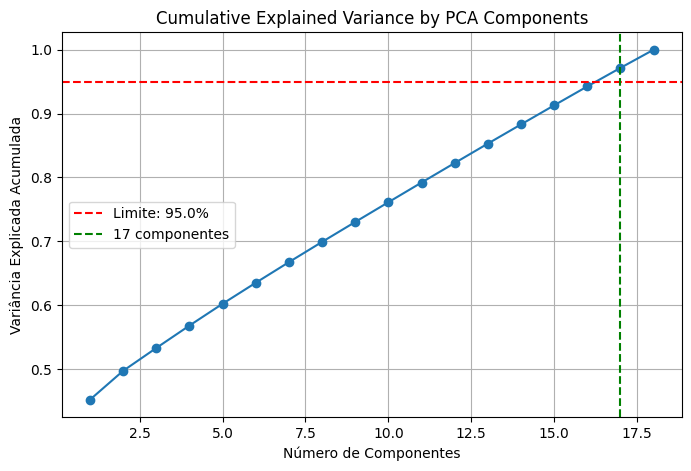

Variância explicada com 17 componentes: 0.97


In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

limite_variancia = 0.95  

# Ajustar PCA para calcular a variância explicada cumulativa
pca = PCA()
data_pca = pca.fit_transform(data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance_ratio)
n_componentes_ideais = np.argmax(cumulative_variance >= limite_variancia) + 1

print(f"Número ideal de componentes principais: {n_componentes_ideais}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
plt.axhline(y=limite_variancia, color='r', linestyle='--', label=f'Limite: {limite_variancia * 100}%')
plt.axvline(x=n_componentes_ideais, color='g', linestyle='--', label=f'{n_componentes_ideais} componentes')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.legend()
plt.grid()
plt.show()

pca_final = PCA(n_components=n_componentes_ideais)
data_pca_final = pca_final.fit_transform(data_scaled)

print(f"Variância explicada com {n_componentes_ideais} componentes: {cumulative_variance[n_componentes_ideais - 1]:.2f}")


In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  
data_selecionado = selector.fit_transform(data_scaled)


In [64]:
### Análise Fatorial

kmo_all, kmo_model = calculate_kmo(data_scaled)
print(f"KMO Test Value: {kmo_model:.3f}")  # KMO > 0.6 é recomendado

# Teste de esfericidade de Bartlett
from scipy.stats import bartlett
bartlett_test = bartlett(*data_scaled.T)
print(f"Bartlett Test: Chi-square = {bartlett_test.statistic:.3f}, p-value = {bartlett_test.pvalue:.3f}")

fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(data_scaled)

factor_loadings = pd.DataFrame(fa.loadings_, index=quantitative_columns, columns=[f"Factor{i+1}" for i in range(3)])
print(factor_loadings)

c:\Python312\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO Test Value: 0.502
Bartlett Test: Chi-square = nan, p-value = nan
                            Factor1   Factor2   Factor3
Cliente_ID                -0.018618  0.095893  0.021159
Qtd_Interacoes_Plataforma -0.046157  0.029321 -0.040908
Gasto_Total                0.090662 -0.009461  0.007713
Qtd_Compras_12meses        0.005709  0.007414  0.088015
Valor_Compras_12meses      0.014797  0.083643 -0.009599
Meses_Compras              0.062006 -0.077300  0.009460
Qtd_Pedidos               -0.056838  0.010203 -0.043249
Pedidos_Mensais           -0.082705  0.083862  0.013787
Meses_Atividade            0.007703 -0.010920  0.058280
Qtd_Pedidos_Devolvidos     0.021055 -0.075996  0.016078
Meses_Devolucoes           0.026378  0.037546  0.138555
Valor_Devolvido            0.008670  0.131378  0.008461
Gasto_Medio_Mensal        -0.006026 -0.001087  0.157471
Qtd_Outros_Fornecedores   -0.000601 -0.117804  0.090912
Valor_Devolvido_Mensal     0.039937  0.102243  0.028397
Porcentagem_Engajamento   -0.071232

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python312\Lib\site-packages\scipy\stats\_morestats.py:3061: RuntimeWarning: divide by zero encountered in divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -
c:\Python312\Lib\site-packages\scipy\stats\_morestats.py:3062: RuntimeWarning: divide by zero encountered in scalar divide
  1.0/(Ntot - k))
c:\Python312\Lib\site-packages\scipy\stats\_morestats.py:3061: RuntimeWarning: invalid value encountered in scalar subtract
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -


In [65]:
correlation_matrix = pd.DataFrame(data_scaled, columns=quantitative_columns).corr()
print(correlation_matrix)

                           Cliente_ID  Qtd_Interacoes_Plataforma  Gasto_Total  \
Cliente_ID                   1.000000                  -0.000666    -0.004516   
Qtd_Interacoes_Plataforma   -0.000666                   1.000000     0.005991   
Gasto_Total                 -0.004516                   0.005991     1.000000   
Qtd_Compras_12meses          0.003011                   0.005858    -0.003707   
Valor_Compras_12meses        0.003470                   0.001993     0.000519   
Meses_Compras               -0.013851                  -0.006849     0.013007   
Qtd_Pedidos                  0.011724                  -0.007896    -0.002492   
Pedidos_Mensais              0.014162                   0.010308    -0.002864   
Meses_Atividade             -0.004085                  -0.004582    -0.007620   
Qtd_Pedidos_Devolvidos      -0.005459                  -0.020756    -0.003385   
Meses_Devolucoes             0.015636                  -0.019853     0.005450   
Valor_Devolvido             

O Que o KMO Significa
O KMO mede a proporção de variância entre variáveis que pode ser explicada pelos fatores. Valores mais altos (
>
0.6
>0.6) indicam que as variáveis estão correlacionadas o suficiente para formar fatores significativos.
Rwsultado do teste: 0.498
Como Melhorar o KMO
Remova Variáveis de Baixa Correlação:

Revise a matriz de correlação e identifique variáveis que têm correlação baixa com as outras.
Variáveis com correlação próxima de zero com todas as outras podem ser removidas.

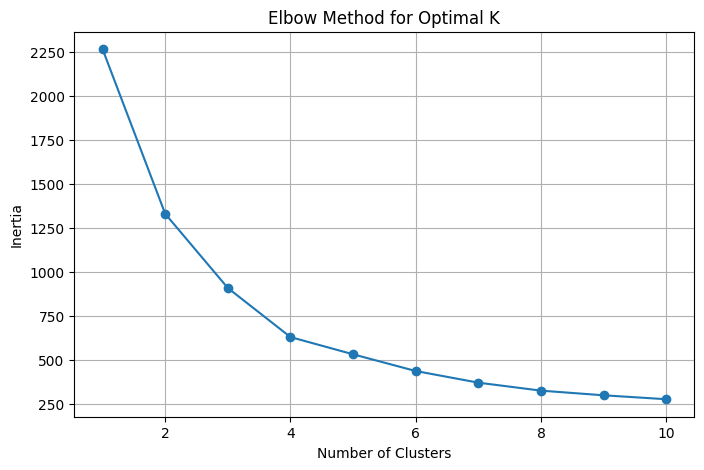

In [66]:
###Clusterização com K-means
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca_2d)
    inertia.append(kmeans.inertia_)

# método Elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(data_pca_2d)

data_scaled['Cluster'] = clusters

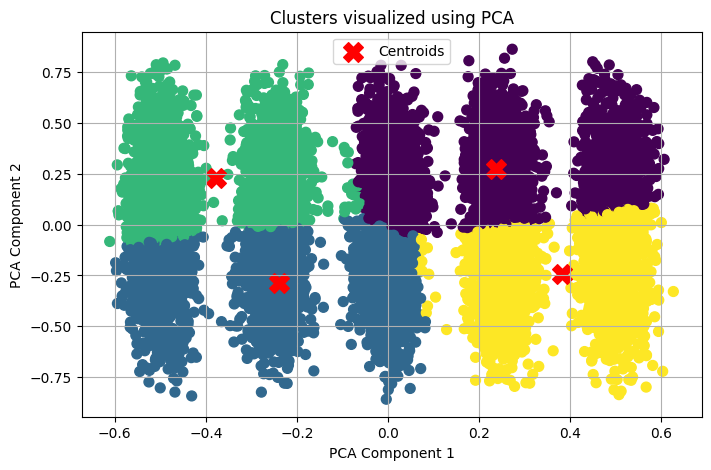

In [67]:
plt.figure(figsize=(8, 5))
plt.scatter(data_pca_2d[:, 0], data_pca_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('Clusters visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

In [68]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette_avg = silhouette_score(data_pca_2d, clusters)
davies_bouldin = davies_bouldin_score(data_pca_2d, clusters)
calinski_harabasz = calinski_harabasz_score(data_pca_2d, clusters)

print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")


Silhouette Score: 0.377
Davies-Bouldin Index: 0.860
Calinski-Harabasz Index: 8649.552


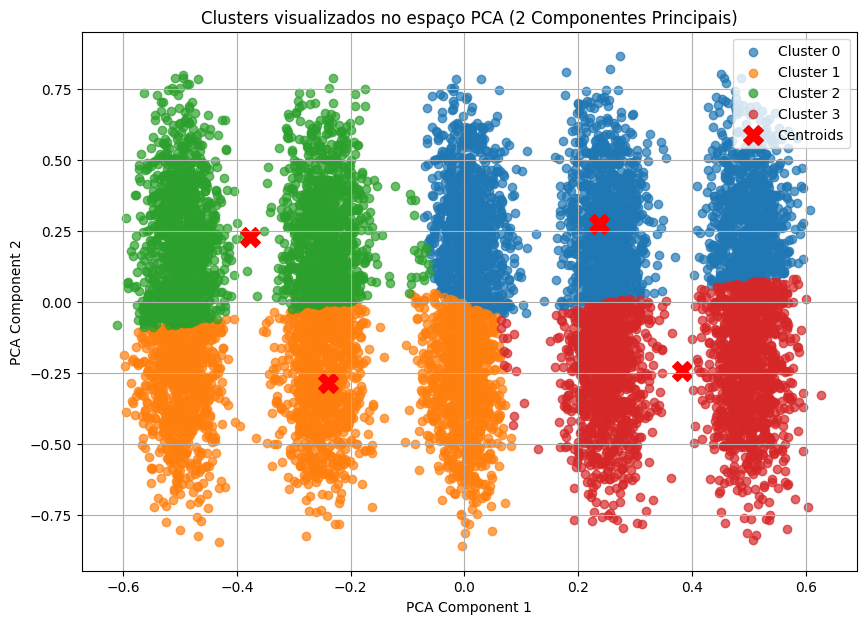

In [69]:
import matplotlib.pyplot as plt

# Plotar os clusters no espaço PCA (2)
plt.figure(figsize=(10, 7))
for cluster in np.unique(clusters):
    plt.scatter(
        data_pca_2d[clusters == cluster, 0],  # Coordenada da 1ª componente principal
        data_pca_2d[clusters == cluster, 1],  # Coordenada da 2ª componente principal
        label=f'Cluster {cluster}',          # Nome do cluster
        alpha=0.7                             # Transparência
    )

# Adicionar os centróides dos clusters
plt.scatter(
    kmeans.cluster_centers_[:, 0],  # Coordenada X do centróide
    kmeans.cluster_centers_[:, 1],  # Coordenada Y do centróide
    s=200,                          # Tamanho do marcador
    c='red',                        # Cor dos centróides
    label='Centroids',              # Legenda
    marker='X'                      # Símbolo
)


plt.title('Clusters visualizados no espaço PCA (2 Componentes Principais)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()
